In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np

## Dataset Loading

In [2]:
from torch_geometric.datasets import WordNet18RR
from torchvision import transforms
transform = transforms.Compose(
    [transforms.ToTensor()])

wn18DataSet = WordNet18RR(root="./data", transform=transforms)

In [3]:
data = wn18DataSet.get(0)

In [4]:
train_dataset = list(zip(
    data['edge_index'][0][  data['train_mask']], 
    data['edge_type'][      data['train_mask']], 
    data['edge_index'][1][  data['train_mask']],
))

test_dataset = list(zip(
    data['edge_index'][0][  data['test_mask']], 
    data['edge_type'][      data['test_mask']], 
    data['edge_index'][1][  data['test_mask']],
))

val_dataset = list(zip(
    data['edge_index'][0][  data['val_mask']], 
    data['edge_type'][      data['val_mask']], 
    data['edge_index'][1][  data['val_mask']],
))
# datasets contain triplets of (head, relation, tail)


# TransE model

In [5]:
from torch.nn import Embedding
torch.norm
class TransE(nn.Module):
    """
    Implementation of multi-relation graph
    embedding model from article: 
    https://proceedings.neurips.cc/paper/2013/file/1cecc7a77928ca8133fa24680a88d2f9-Paper.pdf
    """
    
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(TransE, self).__init__()
        
        uniform_scale = 6/np.sqrt(embedding_dim)
        self.entity_embedding = Embedding(num_entities, embedding_dim)
        self.entity_embedding.weight.data.uniform_(-uniform_scale, uniform_scale)
        self.entity_embedding.weight.data.norm(keepdim=True)
        
        self.relation_embedding = Embedding(num_relations, embedding_dim)
        self.relation_embedding.weight.data.uniform_(-uniform_scale, uniform_scale)
        self.relation_embedding.weight.data.norm(keepdim=True)
    def norm_embedding(self):
        # norm embedding
        self.entity_embedding.weight.data.norm(keepdim=True)
            
    def forward(self, heads, relations, tails):
        """returns prediction of tails embedding and real tails embedding"""
        head_embeddings = self.entity_embedding(heads)
        relation_embeddings = self.relation_embedding(relations)
        tail_embeddings = self.entity_embedding(tails)

        predicted_tail_embeddings = head_embeddings + relation_embeddings
        
        return predicted_tail_embeddings, tail_embeddings
    
    

In [6]:
num_entities = data.num_nodes
num_relations = data.num_edge_types
embedding_dim = 50
learning_rate = 0.01
margin = 1
batch_size = 1024
num_epochs = 120

criterion = nn.MarginRankingLoss(margin=margin)
distance_func = torch.nn.MSELoss(reduction='none')

In [7]:
def count_distance(batch, model):
    """evaluates distance between predicted embedding and true one"""
    head, relation, tail = batch
    pred, label = model(head, relation, tail)
    distance = distance_func(pred, label)
    return distance
        
def make_corrupted_triplets(batch):
    head, relation, tail = batch
    
    # choose randomly, where to change head
    change_head_mask = np.random.random(len(head)) > 0.5
    change_tail_mask = np.bitwise_not(change_head_mask)
    c_head = torch.clone(head)
    c_head[change_head_mask] = torch.randint(num_entities, size=(np.sum(change_head_mask),))
    
    c_tail = torch.clone(tail)
    c_tail[change_tail_mask] = torch.randint(num_entities, size=(np.sum(change_tail_mask),))
    return (c_head, relation, c_tail)


def fit_epoch(train_loader, model, optimizer, criterion=criterion):
    running_loss = 0.0
    processed_data = 0
    for batch in train_loader:
        model.norm_embedding()
        corrupted_batch = make_corrupted_triplets(batch)
        optimizer.zero_grad()
        positive_distance = count_distance(batch, model)
        negative_distance = count_distance(corrupted_batch, model)
        
        loss = criterion(negative_distance, positive_distance, torch.ones_like(positive_distance))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*batch[0].size(0)
        processed_data += batch[0].size(0)
    return running_loss/processed_data



def train(train_ds, optimizer, model, epochs, batch_size=1024):
    history = []
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    for epoch in tqdm(range(epochs)):
        train_loss = fit_epoch(train_loader, model, optimizer)
        history.append(train_loss)
    return history

In [8]:
model = TransE(num_entities, num_relations, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
history = train(train_dataset, optimizer, model, num_epochs, batch_size=batch_size)

  0%|          | 0/120 [00:00<?, ?it/s]

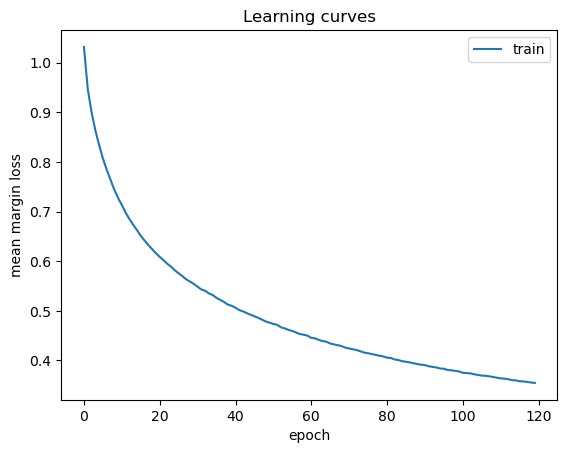

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(history)
plt.legend(["train"])
plt.xlabel("epoch")
plt.ylabel("mean margin loss")
plt.title("Learning curves")
None